In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from scipy.signal import find_peaks, freqz

sys.path.append('..')

from sleeprnn.helpers import reader
from sleeprnn.data import utils
from sleeprnn.common import constants, pkeys, viz

viz.notebook_full_width()
%matplotlib inline

# Load dataset

In [2]:
dataset = reader.load_dataset(constants.CAP_SS_NAME)
fs = dataset.fs

Train size: 16.
Train subjects: 
 ['1-001', '1-002', '1-003', '1-004', '1-005', '1-006', '1-007', '1-008', '1-009', '1-010', '1-011', '1-012', '1-013', '1-014', '1-015', '1-016']
Dataset cap_ss_name with 16 patients.
Loading from checkpoint... Loaded
Global STD computed: 19.1794


# Visualize single page

In [51]:
subject_id = dataset.all_ids[15]

signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
marks = dataset.get_subject_stamps(subject_id, pages_subset=constants.N2_RECORD)
n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
print("Subject", subject_id)
print("Total spindle marks:", marks.shape[0])
print("Total N2 pages:", n2_pages.size)

Subject 1-016
Total spindle marks: 177
Total N2 pages: 686


In [52]:
def draw_single_page(n2_page_index_to_show, dpi):
    selected_page = n2_pages[n2_page_index_to_show]
    start_sample = int(selected_page * dataset.page_size)
    end_sample = start_sample + dataset.page_size

    segment_signal = signal[start_sample:end_sample]
    segment_marks = utils.filter_stamps(marks, start_sample, end_sample)
    sigma_signal = utils.broad_filter(segment_signal, fs, lowcut=11, highcut=16)
    time_axis = np.arange(start_sample, end_sample) / fs

    fig, axes = plt.subplots(2, 1, figsize=(12, 4), dpi=dpi, sharex=True, sharey=True)

    axes[0].set_title("Subject %s, page in record %d" % (subject_id, selected_page))
    axes[0].plot(time_axis, segment_signal, linewidth=0.6)
    axes[1].plot(time_axis, sigma_signal, linewidth=0.6)
    for ax in axes.flatten():
        ax.set_ylim([-150, 150])
        ax.set_xlim([start_sample/fs, end_sample/fs])
        for mark in segment_marks:
            mark = np.clip(mark, a_min=start_sample, a_max=end_sample)
            ax.plot(mark / fs, [-50, -50], linewidth=5, alpha=0.5, color=viz.PALETTE['red'])
        ax.set_xticks(np.linspace(start_sample/fs, end_sample/fs, 41), minor=True)
        ax.grid(axis="x", which="minor")
    plt.tight_layout()
    plt.show()

    # power, freq = utils.power_spectrum(segment_signal, fs)
    # fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
    # ax.plot(freq, power, linewidth=0.7)
    # ax.set_xlim([0, 30])
    # ax.set_xlabel("Frequency (Hz)")
    # plt.show()

In [53]:
n2_page_index_to_show = 146 # 110


dpi = 120
print('Total N2 pages: %d' % n2_pages.size)
style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda page_id: draw_single_page(page_id, dpi=dpi),
    page_id=widgets.IntSlider(
        min=0, max=n2_pages.size-1, step=1, value=n2_page_index_to_show, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

Total N2 pages: 686


A Jupyter Widget

# Check duration histogram

In [7]:
marks_list = dataset.get_stamps(pages_subset=constants.N2_RECORD)

In [8]:
marks = np.concatenate(marks_list, axis=0)
print(marks.shape)

(6770, 2)


In [9]:
durations = (marks[:, 1] - marks[:, 0]) / fs

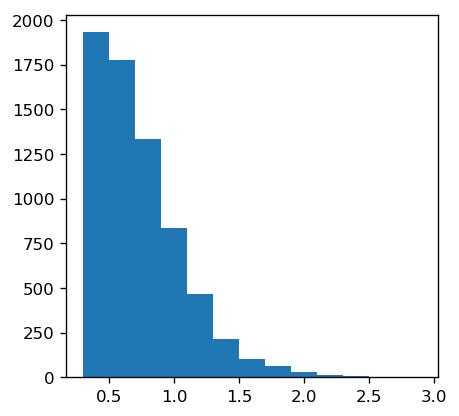

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
ax.hist(durations, bins=np.arange(0.3, 3.001, 0.2))
plt.show()

In [14]:
np.sum(durations < 0.4)

957

In [15]:
thr = 0.5
all_msg = []
all_fractions = []
all_means = []
for subject_id, subject_marks in zip(dataset.all_ids, marks_list):
    subject_durations = (subject_marks[:, 1] - subject_marks[:, 0]) / fs
    mean_duration = np.mean(subject_durations)
    msg = "Suject %s: %3d SS marks, %3d less than %ss (%1.2f%%). Mean duration: %1.3fs" % (
        subject_id, subject_durations.size, np.sum(subject_durations < thr), thr, 100 * np.sum(subject_durations < thr) / subject_durations.size, mean_duration)
    all_msg.append(msg)
    all_fractions.append(-100 * np.sum(subject_durations < thr) / subject_durations.size)
    all_means.append(mean_duration)
idx_sorted = np.argsort(all_fractions)
all_msg = [all_msg[i] for i in idx_sorted]
for msg in all_msg:
    print(msg)
    
print("\n Mean of means in duration: %1.3fs" % np.mean(all_means))
print("Mean of all durations aggregated: %1.3fs" % np.mean(durations))

Suject 1-014:  43 SS marks,  28 less than 0.5s (65.12%). Mean duration: 0.530s
Suject 1-011:  34 SS marks,  21 less than 0.5s (61.76%). Mean duration: 0.542s
Suject 1-008:  65 SS marks,  37 less than 0.5s (56.92%). Mean duration: 0.578s
Suject 1-006: 186 SS marks,  98 less than 0.5s (52.69%). Mean duration: 0.578s
Suject 1-016: 177 SS marks,  89 less than 0.5s (50.28%). Mean duration: 0.602s
Suject 1-003: 101 SS marks,  50 less than 0.5s (49.50%). Mean duration: 0.607s
Suject 1-001: 453 SS marks, 165 less than 0.5s (36.42%). Mean duration: 0.651s
Suject 1-009: 640 SS marks, 210 less than 0.5s (32.81%). Mean duration: 0.721s
Suject 1-013: 240 SS marks,  72 less than 0.5s (30.00%). Mean duration: 0.739s
Suject 1-007: 493 SS marks, 142 less than 0.5s (28.80%). Mean duration: 0.784s
Suject 1-002: 530 SS marks, 152 less than 0.5s (28.68%). Mean duration: 0.746s
Suject 1-015: 825 SS marks, 207 less than 0.5s (25.09%). Mean duration: 0.789s
Suject 1-005: 839 SS marks, 203 less than 0.5s (24.2

## Duration histogram per subject

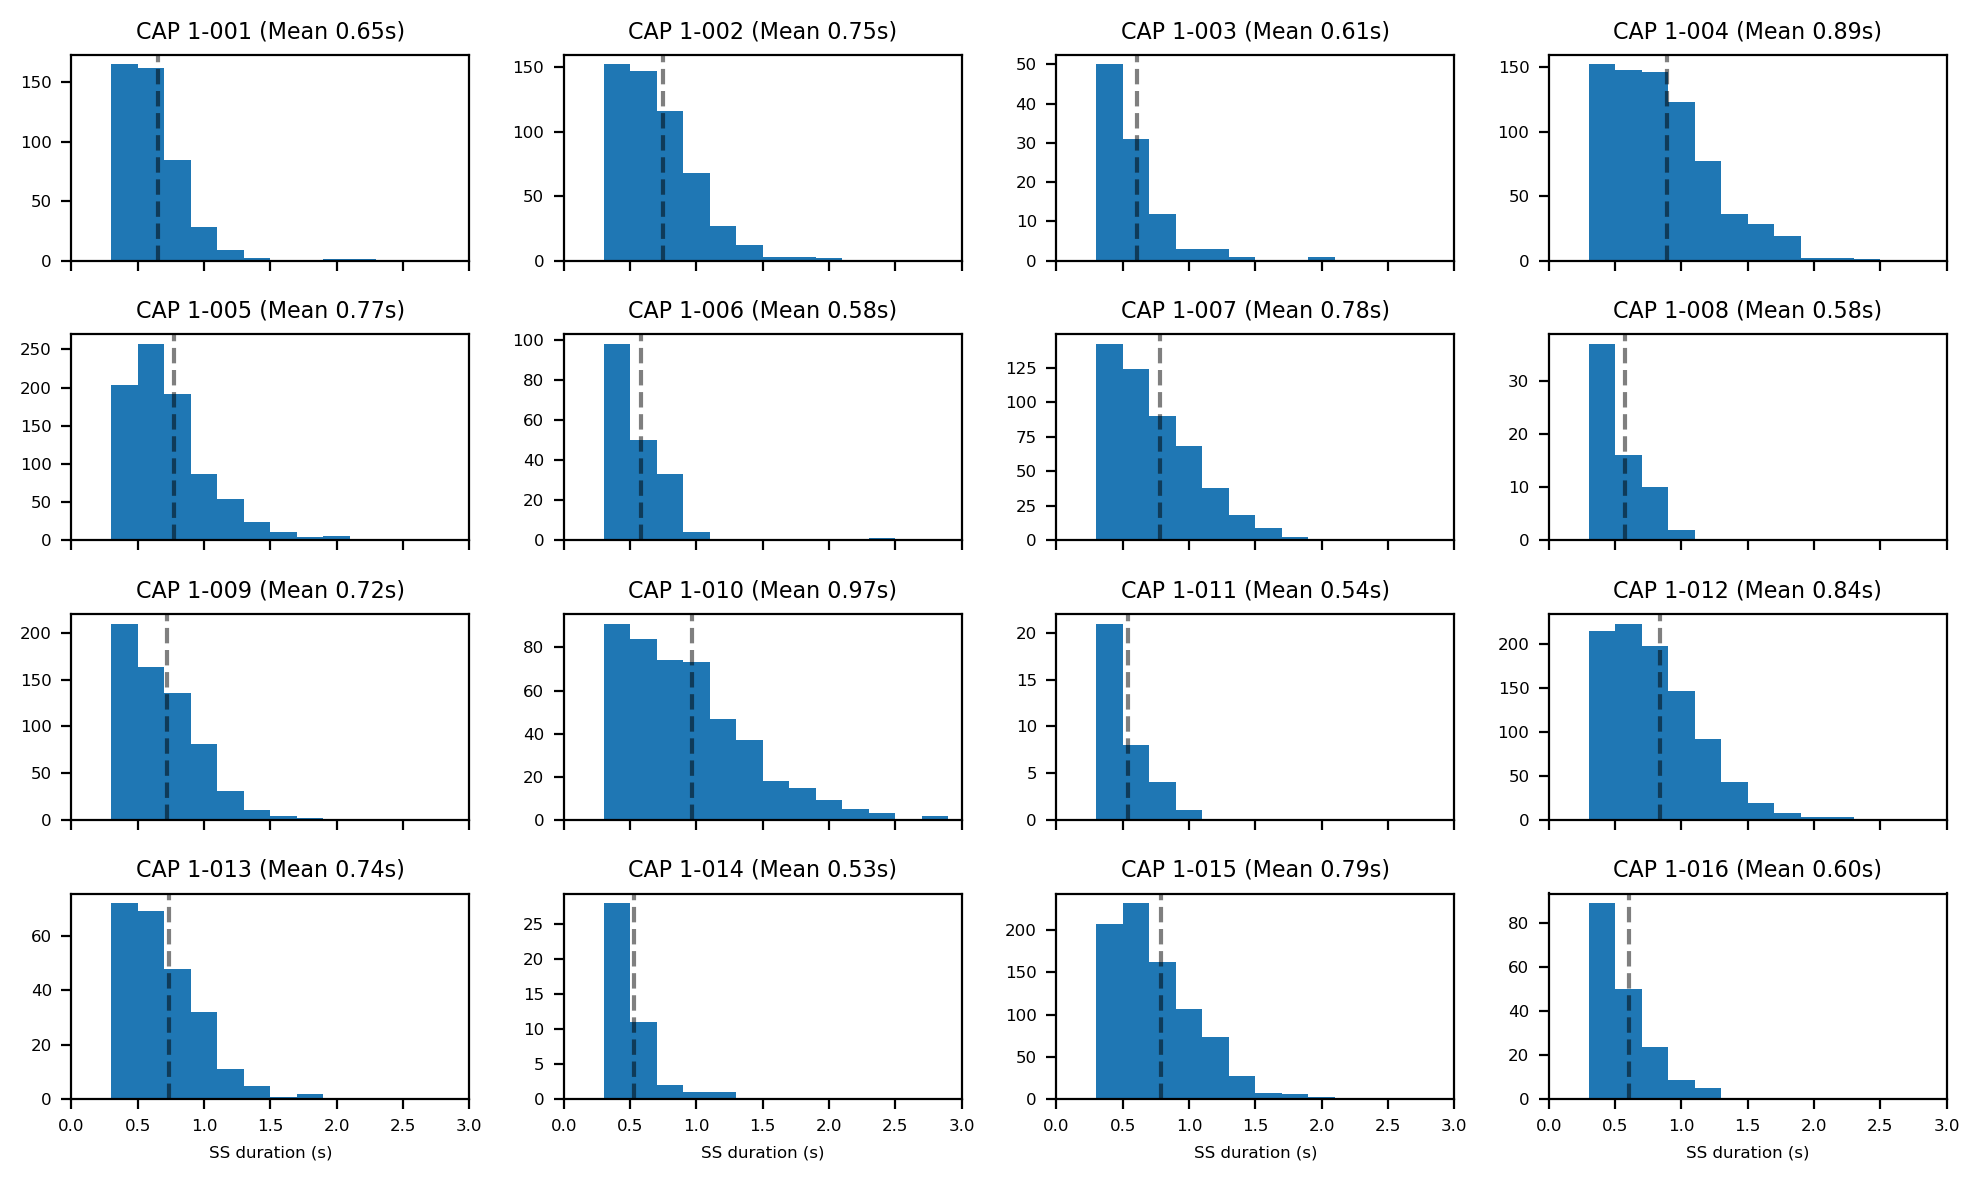

In [27]:
duration_resolution = 0.2
fig, ax = plt.subplots(4, 4, figsize=(10, 6), dpi=200, sharex=True)
for i, (subject_id, subject_marks) in enumerate(zip(dataset.all_ids, marks_list)):
    subject_durations = (subject_marks[:, 1] - subject_marks[:, 0]) / fs
    mean_duration = np.mean(subject_durations)
    row = i // 4
    col = i % 4
    ax[row, col].set_title("CAP %s (Mean %1.2fs)" % (subject_id, mean_duration), fontsize=8)
    ax[row, col].hist(subject_durations, bins=np.arange(0.3, 3.001, duration_resolution))
    ax[row, col].axvline(mean_duration, color='k', linestyle="--", linewidth=1.5, alpha=0.5)
[s_ax.set_xlim([0, 3]) for s_ax in ax[-1, :]]
[s_ax.set_xlabel("SS duration (s)", fontsize=6) for s_ax in ax[-1, :]]
[s_ax.tick_params(labelsize=6) for s_ax in ax.flatten()]
plt.tight_layout()
plt.show()

## Spindle parameters

In [34]:
def analyze_spindle(spindle, fs):
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    central_freq_count = find_peaks(spindle)[0].size / duration
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'pp_amplitude': pp_amplitude,
        'rms': rms,
        'central_freq_count': central_freq_count,
        'central_freq_fft': central_freq_fft
    }
    return results


def listify_dictionaries(list_of_dicts):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
    return dict_of_lists

In [35]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    sigma_signal = utils.broad_filter(signal, fs, lowcut=9, highcut=17)
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for spindle in spindles:
        analysis_results = analyze_spindle(spindle, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

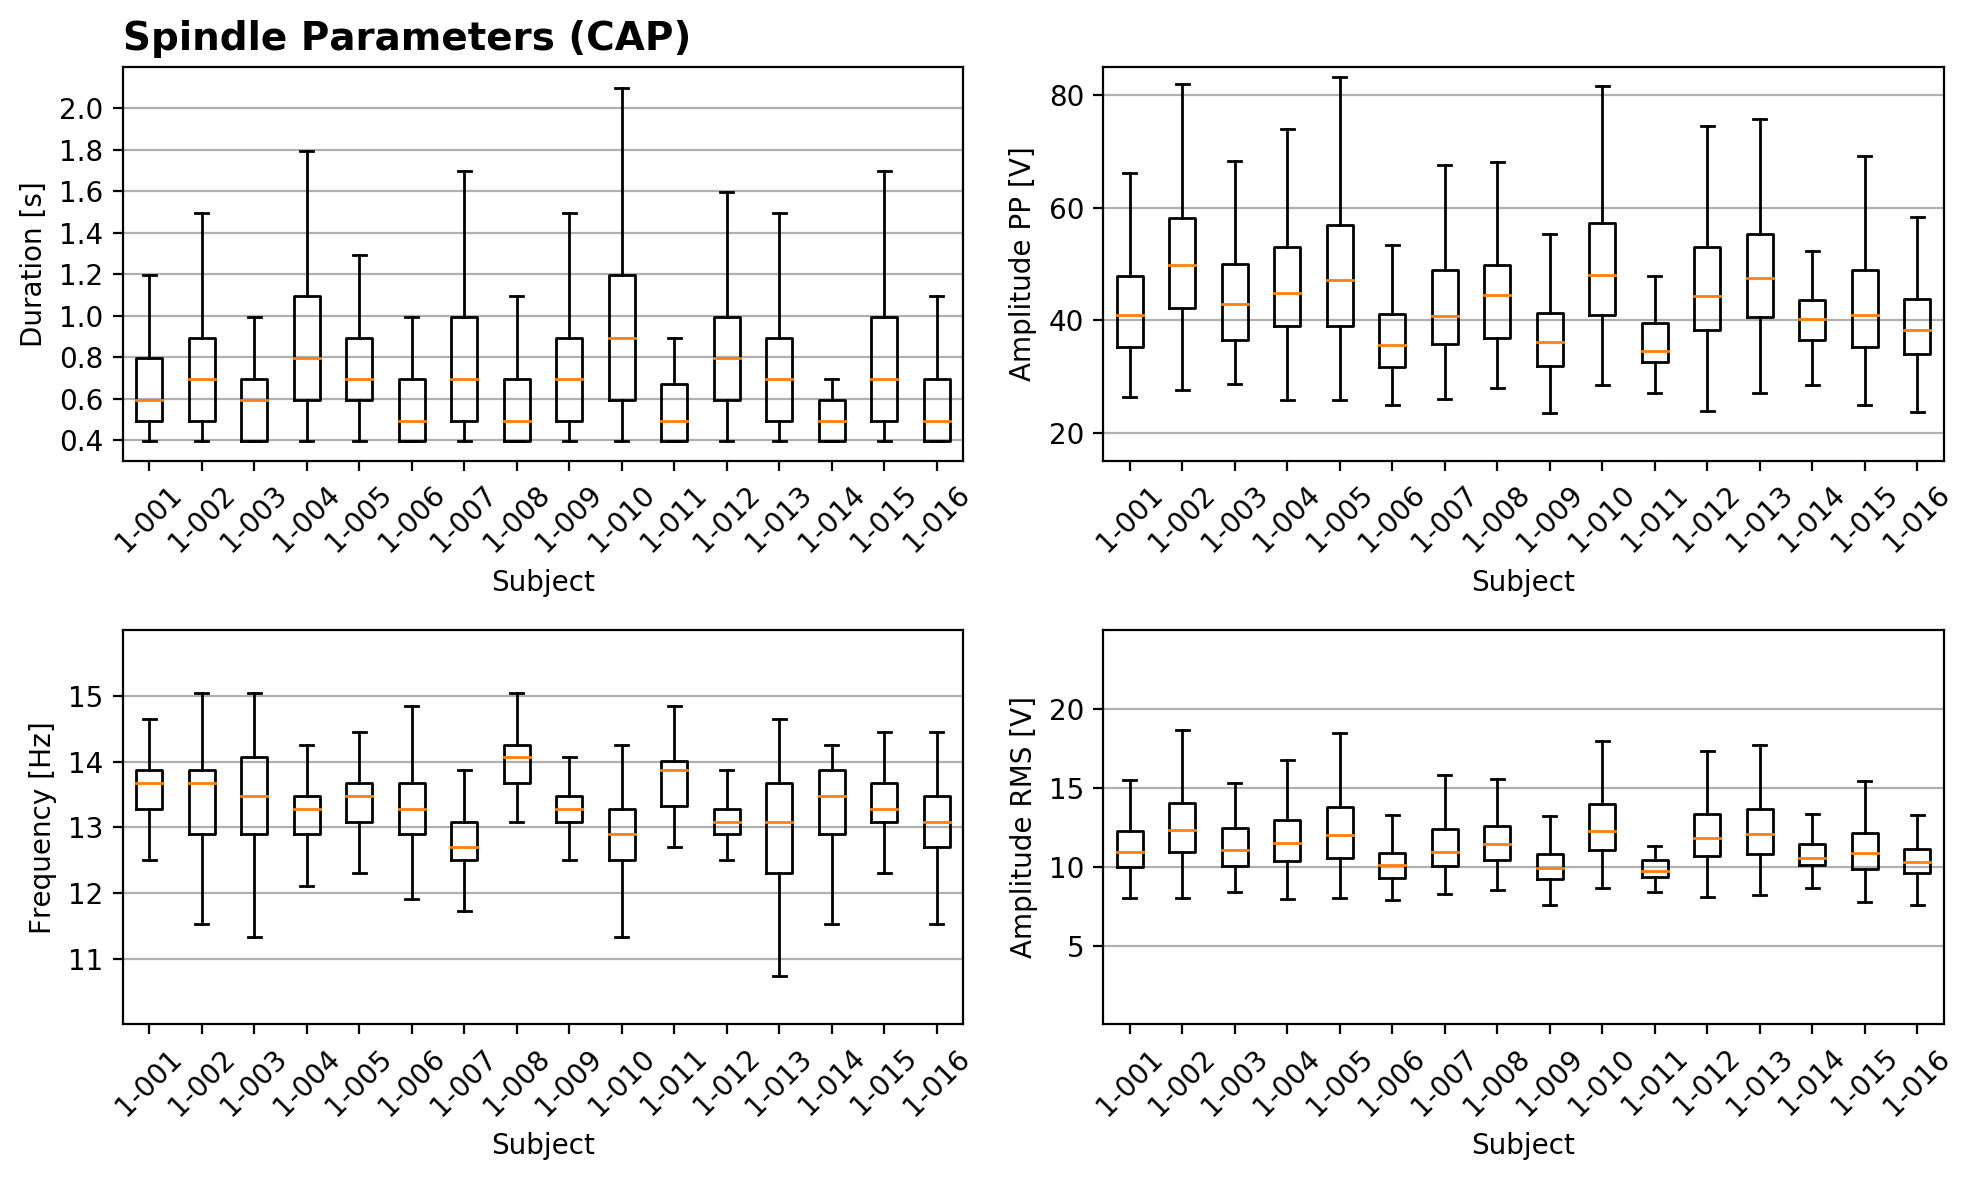

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=200)
showfliers = False

axes[0, 0].set_title("Spindle Parameters (CAP)", fontweight='bold', loc="left", fontsize=14)

# Duration
ax = axes[0, 0]
ax.set_ylabel("Duration [s]")
ax.boxplot(
    [analysis['duration'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax.set_ylim([0.3, 2.2])
ax.tick_params(axis='x', rotation=45)

# Frequency
ax = axes[1, 0]
ax.set_ylabel("Frequency [Hz]")
ax.boxplot(
    [analysis['central_freq_fft'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([11, 12, 13, 14, 15])
ax.set_ylim([10, 16])
ax.set_xlabel("Subject")
ax.tick_params(axis='x', rotation=45)

# Amplitude PP
ax = axes[0, 1]
ax.set_ylabel("Amplitude PP [V]")
ax.boxplot(
    [analysis['pp_amplitude'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([20, 40, 60, 80])
ax.set_ylim([15, 85])
ax.set_xlabel("Subject")
ax.tick_params(axis='x', rotation=45)

# Amplitude RMS
ax = axes[1, 1]
ax.set_ylabel("Amplitude RMS [V]")
ax.boxplot(
    [analysis['rms'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([5, 10, 15, 20])
ax.set_ylim([0, 25])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()